In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.metrics.pairwise import cosine_similarity, rbf_kernel
import os
import pickle
from tqdm import tqdm

In [77]:
# define path to data
__location__ = os.path.abspath("")
datapath = os.path.abspath(os.path.join(__location__, '..', 'data', 'gb_commons_embeedings_subset.feather'))

#read the feather file
df = pd.read_feather(datapath)
df['speech_length'] = df['speech'].apply(lambda x: len(x.split()))
# compute week
df['week'] = df['Date_datetime'].apply(lambda x: x.week)
# #filter out speeches with less than 100 words
df = df[df['speech_length'] > 10]
#filter out speeches where the speaker is not a mp
df = df[df['Speaker_MP'] == 'MP']
df = df[df['Speaker_role'] == 'Regular']
#reset index
df = df.reset_index(drop=True)
df.head()
print(len(df))

,index,ID,Title,Date,Body,Term,Session,Meeting,Sitting,Agenda,...,Speaker_party,Speaker_party_name,Party_status,Speaker_name,Speaker_gender,Speaker_birth,speech,Date_datetime,speech_length,week
0,407774,ParlaMint-GB_2019-03-26-commons.u1,"Minutes of the House of Commons, Daily Session...",2019-03-26,Lower house,57,NaN,NaN,2019-03-26,NaN,...,LAB,Labour,Opposition,"Powell, Lucy Maria",F,-,1. What steps he is taking to help ensure bett...,2019-03-26,27,13
1,407775,ParlaMint-GB_2019-03-26-commons.u2,"Minutes of the House of Commons, Daily Session...",2019-03-26,Lower house,57,NaN,NaN,2019-03-26,NaN,...,CON,Conservative,None,"Hancock, Matthew John David",M,-,The Department of Health and Social Care works...,2019-03-26,33,13
2,407776,ParlaMint-GB_2019-03-26-commons.u3,"Minutes of the House of Commons, Daily Session...",2019-03-26,Lower house,57,NaN,NaN,2019-03-26,NaN,...,LAB,Labour,Opposition,"Powell, Lucy Maria",F,-,I thank the Secretary of State very much for t...,2019-03-26,95,13
3,407777,ParlaMint-GB_2019-03-26-commons.u4,"Minutes of the House of Commons, Daily Session...",2019-03-26,Lower house,57,NaN,NaN,2019-03-26,NaN,...,CON,Conservative,None,"Hancock, Matthew John David",M,-,I agree with the hon. Lady on both counts. My ...,2019-03-26,99,13
4,407778,ParlaMint-GB_2019-03-26-commons.u5,"Minutes of the House of Commons, Daily Session...",2019-03-26,Lower house,57,NaN,NaN,2019-03-26,NaN,...,CON,Conservative,None,"Crouch, Tracey Elizabeth Anne",F,-,"On Friday, I met two clinical commissioning gr...",2019-03-26,81,13


In [18]:
# define pickle path
pklpath = os.path.abspath(os.path.join(__location__, '..', 'data', 'ParlaMint_GB_commons_embeddings_truncated.pkl'))

with (open(pklpath, "rb")) as openfile:
    while True:
        try:
            embeddings = pickle.load(openfile)
        except EOFError:
            break

In [19]:
vectors = np.array(list(embeddings.values()))
vkeys = np.array(list(embeddings.keys()))

In [20]:
print(len(df))
print(len(vkeys))

1000
472782


In [63]:
#list distinct dates in df
dates = df['Date'].unique()
dfd = pd.DataFrame(columns=['Date', 'cos_sim', 'party_distance'])
print(type(dfd))

for d in tqdm(dates):
    #filter df to only include speeches from date d
    df_d = df[df['Date'] == d]
    #filter vectors to only include speeches from date d
    vectors_d = vectors[np.isin(vkeys, df_d['ID'])]
    #calculate mean vector for date d
    mean_vector_d = np.mean(vectors_d, axis=0)
    #calculate cosine similarity between mean vector and all vectors for date d
    cos_sim_d = cosine_similarity(vectors_d, mean_vector_d.reshape(1, -1))
    #list distinct parties in df_d
    parties = df_d['Speaker_party'].unique()
    #calculate mean vector for each party
    mean_vectors = []
    for p in parties:
        #filter vectors to only include speeches from party p
        vectors_p = vectors_d[np.isin(df_d['Speaker_party'], p)]
        #calculate mean vector for party p
        mean_vector_p = np.mean(vectors_p, axis=0)
        mean_vectors.append(mean_vector_p)
    #compute party weights
    party_weights = np.array([len(df_d[df_d['Speaker_party'] == p]) for p in parties])
    party_weights = party_weights / np.sum(party_weights)
    #compute party vector distances to mean vector
    party_distances = np.array([np.linalg.norm(mean_vector_d - mean_vector_p) for mean_vector_p in mean_vectors])
    party_distances = party_distances @ party_weights.T
    prtd = np.sum(party_distances)
    #compute mean cosine similarity for date d
    cos_sim = np.mean(cos_sim_d)
    r = pd.DataFrame([[d, cos_sim, prtd]], columns=['Date', 'cos_sim', 'party_distance'])
    #add cosine similarity to dfx
    dfd = pd.concat([dfd, r])

<class 'pandas.core.frame.DataFrame'>


100%|██████████| 93/93 [07:05<00:00,  4.58s/it]


In [104]:
#list distinct weeks in df
weeks = df['week'].unique()
dfw = pd.DataFrame(columns=['week', 'cos_sim', 'rbf_sim', 'party_distance'])
print(type(dfw))

for w in tqdm(weeks):
    #filter df to only include speeches from week w
    df_w = df[df['week'] == w]
    #filter vectors to only include speeches from week w
    vectors_w = vectors[np.isin(vkeys, df_w['ID'])]
    #calculate mean vector for date d
    mean_vector_w = np.mean(vectors_w, axis=0)
    #calculate cosine similarity between mean vector and all vectors for week w
    cos_sim_w = cosine_similarity(vectors_w, mean_vector_w.reshape(1, -1))
    rbf_sim_w = rbf_kernel(vectors_w, mean_vector_w.reshape(1, -1))
    #list distinct parties in df_w
    parties = df_w['Speaker_party'].unique()
    #calculate mean vector for each party
    mean_vectors = []
    for p in parties:
        #filter vectors to only include speeches from party p
        vectors_p = vectors_w[np.isin(df_w['Speaker_party'], p)]
        #calculate mean vector for party p
        mean_vector_p = np.mean(vectors_p, axis=0)
        mean_vectors.append(mean_vector_p)
    #compute party weights
    party_weights = np.array([len(df_w[df_w['Speaker_party'] == p]) for p in parties])
    party_weights = party_weights / np.sum(party_weights)
    #compute party vector distances to mean vector
    party_distances = np.array([np.linalg.norm(mean_vector_w - mean_vector_p) for mean_vector_w in mean_vectors])
    party_distances = party_distances @ party_weights.T
    prtd = np.sum(party_distances)
    #compute mean cosine similarity for week w
    cos_sim = np.mean(cos_sim_w)
    rbf_sim = np.mean(rbf_sim_w)
    r = pd.DataFrame([[w, cos_sim, rbf_sim, prtd]], columns=['week', 'cos_sim', 'rbf_sim', 'party_distance'])
    #add cosine similarity to dfw
    dfw = pd.concat([dfw, r])

<class 'pandas.core.frame.DataFrame'>


100%|██████████| 23/23 [19:01<00:00, 49.62s/it]


nulls
0
17


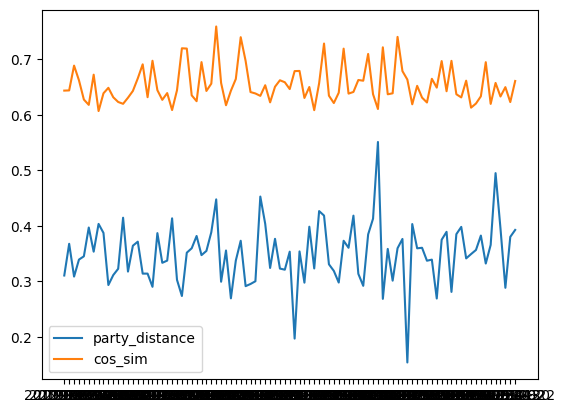

In [74]:
# print(dfx.tail(50))
# count nulls
print('nulls')
print(dfd['party_distance'].isnull().sum())
print(len(dfd[dfd['party_distance'] < 0.3]))
# plot cosine similarity over time
# plt.figure(figsize=(100,60))
plt.plot(dfd['Date'], dfd['party_distance'])
plt.plot(dfd['Date'], dfd['cos_sim'])
plt.legend(['party_distance', 'cos_sim'])
plt.show()

  week   cos_sim   rbf_sim  party_distance
0    2  0.602360  0.993773        1.416543
1    3  0.608881  0.993802        1.754988
2    4  0.596483  0.993679        2.027248
3    5  0.596378  0.993675        0.973186
4    6  0.586266  0.993610        1.644780


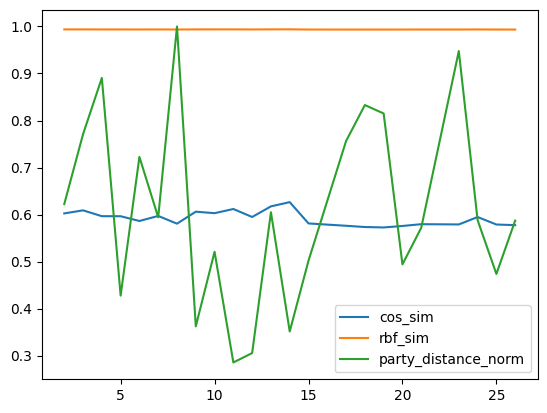

In [107]:
weekly = dfw.sort_values(by=['week']).reset_index(drop=True)
print(weekly.head())
weekly['party_distance_norm'] = weekly['party_distance'] / np.max(weekly['party_distance'])
plt.plot(weekly['week'], weekly['cos_sim'])
plt.plot(weekly['week'], weekly['rbf_sim'])
plt.plot(weekly['week'], weekly['party_distance_norm'])
plt.legend(['cos_sim', 'rbf_sim', 'party_distance_norm'])
plt.show()
